In [1]:
import sys
from itertools import chain, product
import pandas as pd
from rdkit.Chem import PandasTools

sys.path.append('..')
from torch import LongTensor
from torch_geometric.datasets import QM9

from src.models.egnn import EquivariantGNN
from src.tools import *

In [2]:
def num_heavy_atoms(qm9_data: Data) -> int:
    """Count the number of heavy atoms in a torch geometric
    Data object.

    Parameters
    ----------
    qm9_data : Data
        A pytorch geometric qm9 data object representing a small molecule
         where atomic numbers are stored in a
        tensor-valued attribute `qm9_data.z`

    Returns
    -------
    int
        The number of heavy atoms in the molecule.
    """
    # every atom with atomic number other than 1 is heavy
    return (qm9_data.z != 1).sum()


def complete_edge_index(n: int) -> LongTensor:
    """
    Constructs a complete edge index.

    NOTE: representing complete graphs
    with sparse edge tensors is arguably a bad idea
    due to performance reasons, but for this tutorial it'll do.

    Parameters
    ----------
    n : int
        the number of nodes in the graph.

    Returns
    -------
    LongTensor
        A PyTorch `edge_index` represents a complete graph with n nodes,
        without self-loops. Shape (2, n).
    """
    # filter removes self loops
    edges = list(filter(lambda e: e[0] != e[1], product(range(n), range(n))))
    return torch.tensor(edges, dtype=torch.long).T


def add_complete_graph_edge_index(data: Data) -> Data:
    """
    On top of any edge information already there,
    add a second edge index that represents
    the complete graph corresponding to a  given
    torch geometric data object

    Parameters
    ----------
    data : Data
        The torch geometric data object.

    Returns
    -------
    Data
        The torch geometric `Data` object with a new
        attribute `complete_edge_index` as described above.
    """
    data.complete_edge_index = complete_edge_index(data.num_nodes)
    return data

In [3]:
dataset = QM9(
    '../data/QM9',  # root directory where the dataset should be saved
    # Filter out molecules with more than 8 heavy atoms
    pre_filter=lambda data: num_heavy_atoms(data) < 9,
    # implement point cloud adjacency as a complete graph
    pre_transform=add_complete_graph_edge_index,
)

In [4]:
dataset[0].to_dict()

{'x': tensor([[0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 4.],
         [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]),
 'edge_index': tensor([[0, 0, 0, 0, 1, 2, 3, 4],
         [1, 2, 3, 4, 0, 0, 0, 0]]),
 'edge_attr': tensor([[1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.]]),
 'y': tensor([[    0.0000,    13.2100,   -10.5499,     3.1865,    13.7363,    35.3641,
              1.2177, -1101.4878, -1101.4098, -1101.3840, -1102.0229,     6.4690,
            -17.1722,   -17.2868,   -17.3897,   -16.1519,   157.7118,   157.7100,
            157.7070]]),
 'pos': tensor([[-1.2700e-02,  1.0858e+00,  8.0000e-03],
         [ 2.2000e-03, -6.0000e-03,  2.0000e-03],
         [ 1.0117e

In [5]:
dir(dataset[0])

['__annotations__',
 '__call__',
 '__cat_dim__',
 '__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__inc__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_edge_attr_cls',
 '_edge_to_layout',
 '_edges_to_layout',
 '_get_edge_index',
 '_get_tensor',
 '_get_tensor_size',
 '_multi_get_tensor',
 '_put_edge_index',
 '_put_tensor',
 '_remove_edge_index',
 '_remove_tensor',
 '_store',
 '_tensor_attr_cls',
 '_to_type',
 'apply',
 'apply_',
 'batch',
 'clone',
 'coalesce',
 'concat',
 'contains_isolated_nodes',
 'contains_self_loops',
 'contiguous',
 'coo

C:\Users\cabe\AppData\Local\Temp\ipykernel_28080\295714153.py:10: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


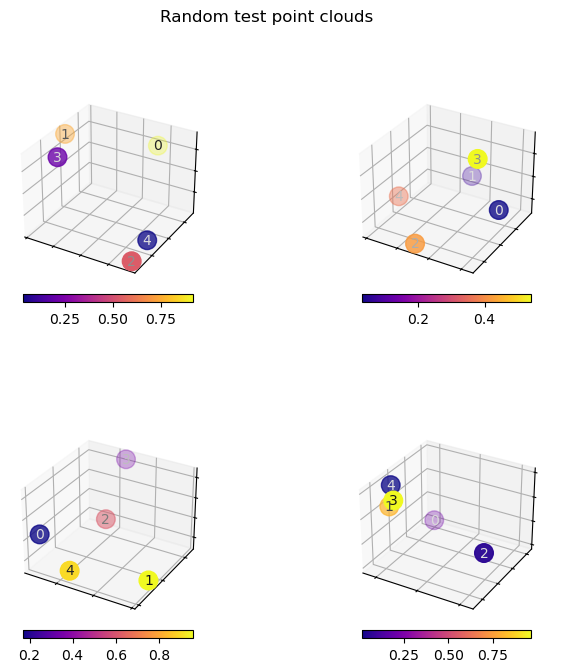

In [6]:
# testing
fig = plt.figure(figsize=(8, 8))

for ax_pos in [221, 222, 223, 224]:
    pos = np.random.rand(3, 5)
    color = np.random.rand(5)
    plot_point_cloud_3d(fig, ax_pos, color, pos)

fig.suptitle("Random test point clouds")
fig.tight_layout()

In [12]:
df = PandasTools.LoadSDF('../data/QM9/raw/gdb9.sdf')
df.shape

[19:20:56] Explicit valence for atom # 1 C, 5, is greater than permitted
[19:20:56] ERROR: Could not sanitize molecule ending on line 9097
[19:20:56] ERROR: Explicit valence for atom # 1 C, 5, is greater than permitted
[19:20:56] Explicit valence for atom # 1 C, 5, is greater than permitted
[19:20:56] ERROR: Could not sanitize molecule ending on line 35785
[19:20:56] ERROR: Explicit valence for atom # 1 C, 5, is greater than permitted
[19:20:56] Explicit valence for atom # 4 C, 5, is greater than permitted
[19:20:56] ERROR: Could not sanitize molecule ending on line 62866
[19:20:56] ERROR: Explicit valence for atom # 4 C, 5, is greater than permitted
[19:20:56] Explicit valence for atom # 2 C, 5, is greater than permitted
[19:20:56] ERROR: Could not sanitize molecule ending on line 66832
[19:20:56] ERROR: Explicit valence for atom # 2 C, 5, is greater than permitted
[19:20:56] Explicit valence for atom # 2 C, 5, is greater than permitted
[19:20:56] ERROR: Could not sanitize molecule en

(133247, 2)

In [5]:
props = pd.read_csv('../data/QM9/raw/gdb9.sdf.csv', header=1)
props.shape

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_iter',
 'align2d',
 'append',
 'config',
 'create_index',
 'dataframe',
 'draw_grid',
 'enumerate',
 'extend',
 'fragment',
 'from_dataframe',
 'get_atom_fpt',
 'get_infile',
 'get_smiles_writer',
 'grid_image',
 'head',
 'inchikey',
 'index',
 'infile',
 'iter_molecules',
 'iter_sdf',
 'iter_smi',
 'load',
 'logger',
 'modified',
 'molecules',
 'multi',
 'name',
 'operators',
 'pains',
 'pickle',
 'prepare_molecules',
 'rdkit',
 'read',
 'read_from_index',
 'read_index',
 'removeHs',
 'reset',
 'sanitize',
 'scaffold',
 'select',
 'set_iter',
 'size',
 'sort',
 

In [7]:
mols[0].get_properties()

{'_Name': 'gdb_1',
 '_MolFileInfo': '  -OEChem-03231823243D',
 '_MolFileComments': '',
 '_MolFileChiralFlag': '0'}

In [9]:
!more '../data/QM9/raw/gdb9.sdf'

Par�metro no v�lido: /data
